### Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from statsmodels.tsa.seasonal import seasonal_decompose


### 📌 Load & Preprocess Data


##### Define student ID and file URLs

In [6]:
student_id = "001349129"
base_url = f"https://tinyurl.com/ChrisCoDV/{student_id}"
urls = {
    "customers": f"{base_url}/StoreDailyCustomers.csv",
    "marketing": f"{base_url}/StoreMarketing.csv",
    "overheads": f"{base_url}/StoreOverheads.csv",
    "size": f"{base_url}/StoreSize.csv",
    "staff": f"{base_url}/StoreStaff.csv"
}

##### Load customer data (daily granularity)

In [9]:
df_customers = pd.read_csv(urls["customers"])
df_customers['Date'] = pd.to_datetime(df_customers['Date'])
df_customers_long = df_customers.melt(id_vars=["Date"], var_name="Store", value_name="Customers")

##### Load and merge summary data (store granularity)

In [12]:
dfs = [pd.read_csv(url).rename(columns={"Id": "Store"}) for url in [urls["marketing"], urls["overheads"], urls["size"], urls["staff"]]]
df_summary = dfs[0].merge(dfs[1], on="Store").merge(dfs[2], on="Store").merge(dfs[3], on="Store")
df_summary = df_summary.merge(df_customers_long.groupby("Store")["Customers"].sum().reset_index(), on="Store")

### 📌 Feature Engineering

##### Calculate key performance metrics

In [16]:
df_summary['CustomersPer£'] = df_summary['Customers'] / df_summary['Marketing (£)']
df_summary['CustomersPerSqm'] = df_summary['Customers'] / df_summary['Size (msq)']
df_summary['CustomersPerStaff'] = df_summary['Customers'] / df_summary['Staff']

##### Identify store operational status

In [19]:
def identify_store_status(store_series):
    non_zero = store_series[store_series > 0]
    if len(non_zero) == 0: return "Closed"
    if non_zero.index[0] > pd.Timestamp('2023-04-01'): return "New"
    if non_zero.index[-1] < pd.Timestamp('2023-09-01'): return "Closed"
    return "Operational"

store_status = {store: identify_store_status(df_customers.set_index('Date')[store]) for store in df_customers.columns[1:]}
df_summary['Status'] = df_summary['Store'].map(store_status)

##### Segment stores based on customer volume

In [22]:
percentiles = df_summary['Customers'].quantile([0.33, 0.66]).values
df_summary['VolumeSegment'] = pd.cut(df_summary['Customers'],
                                     bins=[0, percentiles[0], percentiles[1], np.inf],
                                     labels=['Low', 'Medium', 'High'])

### 📌 Interactive Graphs (Altair)


#### 1️⃣**Marketing Spend Effectiveness Chart**  

This interactive scatter plot visualizes the relationship between **Marketing Spend (£)** and **Total Customers**, with colors representing **Volume Segments**.  

##### **User Interactions:**  
✅ **Hover** over points to see **Store Name, Marketing Spend, Customers, and Size**.  
✅ **Pan & Zoom** using click-and-drag or scroll to explore different spending levels.  
✅ **Dynamic Colors** distinguish store performance by volume segment.  
✅ **Adjustable Axes** allow a detailed view of marketing efficiency.  

**How to Use:**  
- Identify trends between marketing spend and customer footfall.  
- Compare store performance by hovering over data points.  
- Spot outliers and assess marketing effectiveness efficiently.

In [26]:
chart_marketing = alt.Chart(df_summary).mark_circle(size=100).encode(
    x=alt.X('Marketing (£):Q', title="Marketing Spend (£)"),
    y=alt.Y('Customers:Q', title="Total Customers"),
    color=alt.Color('VolumeSegment:N', scale=alt.Scale(scheme='viridis')),
    tooltip=['Store', 'Marketing (£)', 'Customers', 'Size (msq)']
).properties(
    width=600, height=400,
    title="Marketing Spend Effectiveness"
).interactive()

chart_marketing.display()

alt.Chart(...)


#### 2️⃣**Space Utilization Efficiency Chart**  

This interactive scatter plot examines **Store Size (m²)** vs. **Customers Per Square Meter**, highlighting space utilization efficiency across stores.  

##### **User Interactions:**  
✅ **Hover** over points to view **Store Name, Size, Total Customers, and Customers Per Sqm**.  
✅ **Pan & Zoom** to explore different store sizes and utilization rates.  
✅ **Dynamic Colors** represent different **Volume Segments** for quick comparisons.  
✅ **Bubble Size** scales with total customers, making high-traffic stores easily identifiable.  

**How to Use:**  
- Assess how efficiently different stores utilize their space.  
- Identify high-performing stores with a high **Customers Per Sqm** ratio.  
- Compare store sizes to their customer density for strategic insights.

In [29]:
chart_size_utilization = alt.Chart(df_summary).mark_circle(size=100).encode(
    x=alt.X('Size (msq):Q', title="Store Size (m²)"),
    y=alt.Y('CustomersPerSqm:Q', title="Customers Per Square Meter"),
    color=alt.Color('VolumeSegment:N', scale=alt.Scale(scheme='viridis')),
    size=alt.Size('Customers:Q', scale=alt.Scale(range=[50, 500])),
    tooltip=['Store', 'Size (msq)', 'Customers', 'CustomersPerSqm']
).properties(
    width=600, height=400,
    title="Space Utilization Efficiency"
).interactive()

chart_size_utilization.display()

alt.Chart(...)

### 📌 Static Visualizations (Seaborn & Matplotlib)

##### 3️⃣ Customer Volume Distribution

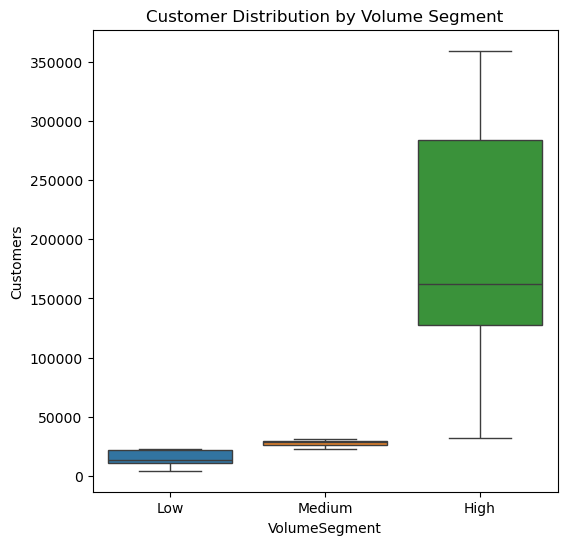

In [33]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=df_summary, x='VolumeSegment', y='Customers', hue='VolumeSegment')
plt.title('Customer Distribution by Volume Segment')
plt.show()


##### 4️⃣ Staff Productivity Analysis

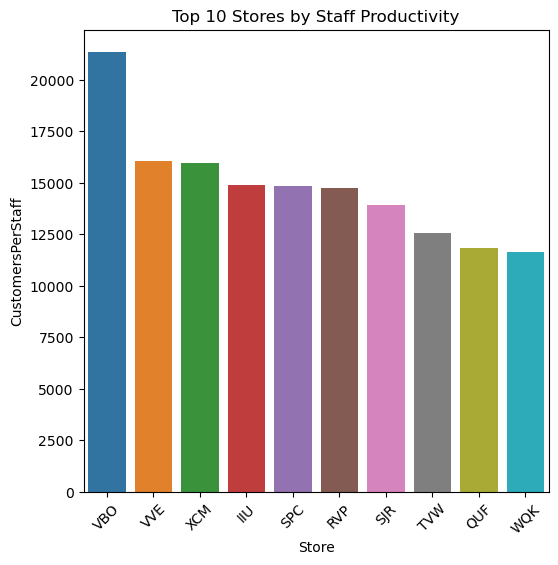

In [36]:
plt.figure(figsize=(6, 6))
sns.barplot(data=df_summary.sort_values('CustomersPerStaff', ascending=False).head(10),
            x='Store', y='CustomersPerStaff', hue='Store', legend=False)
plt.title('Top 10 Stores by Staff Productivity')
plt.xticks(rotation=45)
plt.show()

##### 5️⃣ Overhead Cost Analysis

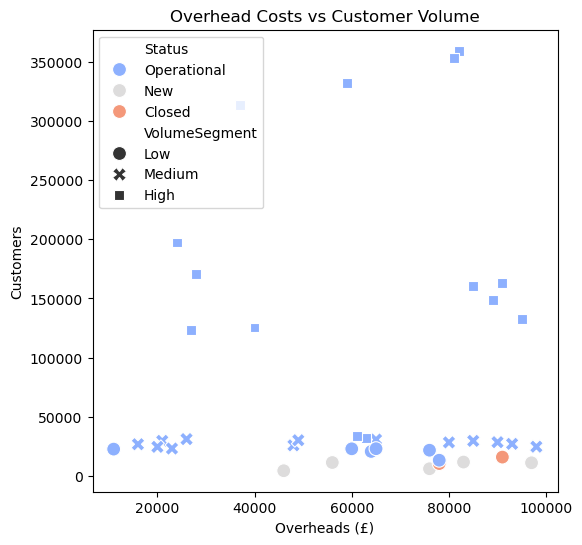

In [39]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_summary, x='Overheads (£)', y='Customers', 
               hue='Status', style='VolumeSegment', palette='coolwarm', s=100)
plt.title('Overhead Costs vs Customer Volume')
plt.show()

##### 6️⃣ Correlation Matrix

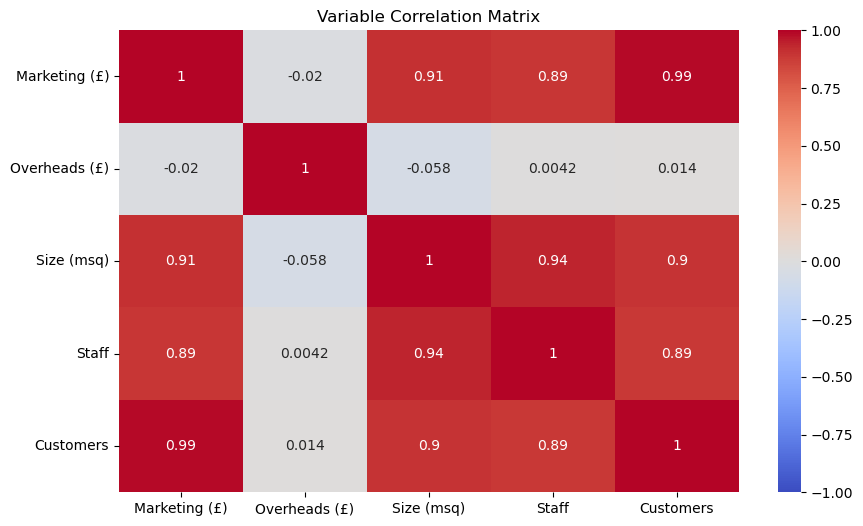

In [42]:
plt.figure(figsize=(10, 6))
corr_matrix = df_summary[['Marketing (£)', 'Overheads (£)', 'Size (msq)', 'Staff', 'Customers']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Variable Correlation Matrix')
plt.show()


###  Seasonal Trend Analysis

#### Top 3 stores analysis

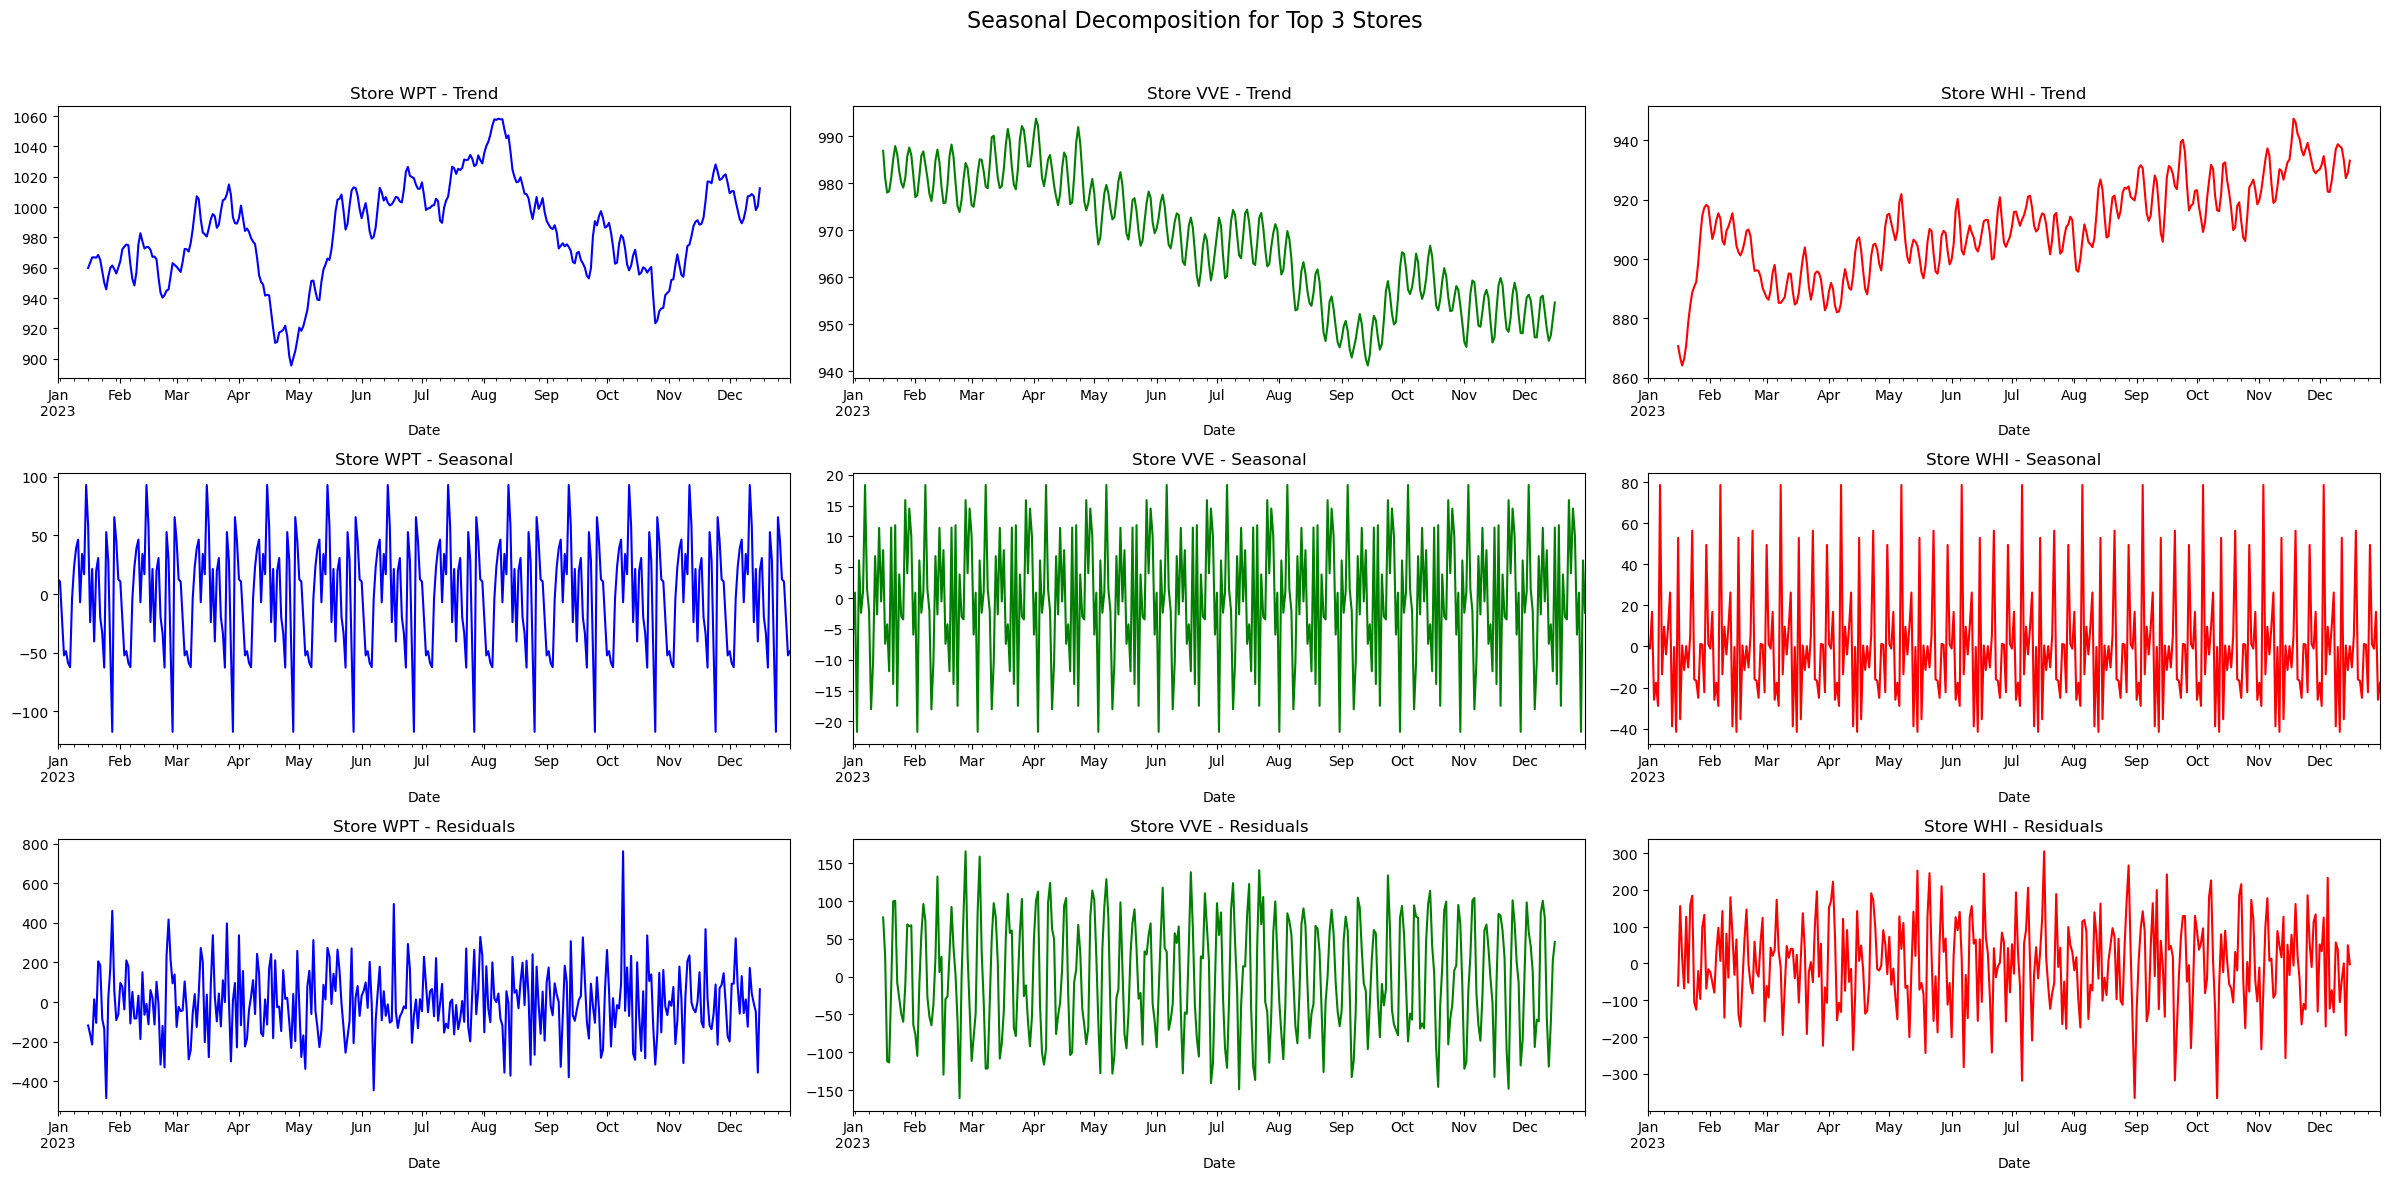

In [46]:
def plot_seasonal_decomposition_combined(stores,text):
    fig, axes = plt.subplots(3, 3, figsize=(24, 12))  # 3 rows (Trend, Seasonal, Residuals) x 3 columns (stores)
    fig.suptitle(f'Seasonal Decomposition for {text} 3 Stores', fontsize=16)

    colors = ['b', 'g', 'r']  # Blue, Green, Red for each store

    for i, store_id in enumerate(stores):
        store_data = df_customers_long[df_customers_long['Store'] == store_id].set_index('Date')
        if store_data['Customers'].isna().sum() > 0:
            store_data['Customers'].fillna(store_data['Customers'].median(), inplace=True)  # Handle missing values
        
        try:
            result = seasonal_decompose(store_data['Customers'], model='additive', period=30)
            
            # Plot Trend
            result.trend.plot(ax=axes[0, i], title=f'Store {store_id} - Trend', color=colors[i])
            
            # Plot Seasonal
            result.seasonal.plot(ax=axes[1, i], title=f'Store {store_id} - Seasonal', color=colors[i])
            
            # Plot Residuals
            result.resid.plot(ax=axes[2, i], title=f'Store {store_id} - Residuals', color=colors[i])
            
        except ValueError:
            print(f"Skipping store {store_id} due to insufficient data for decomposition.")

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate the suptitle
    plt.show()

# Get top 3 stores by customer volume
top_stores = df_summary.nlargest(3, 'Customers')['Store'].tolist()

# Plot combined seasonal decomposition
plot_seasonal_decomposition_combined(top_stores,'Top')

#### Bottom 3 stores

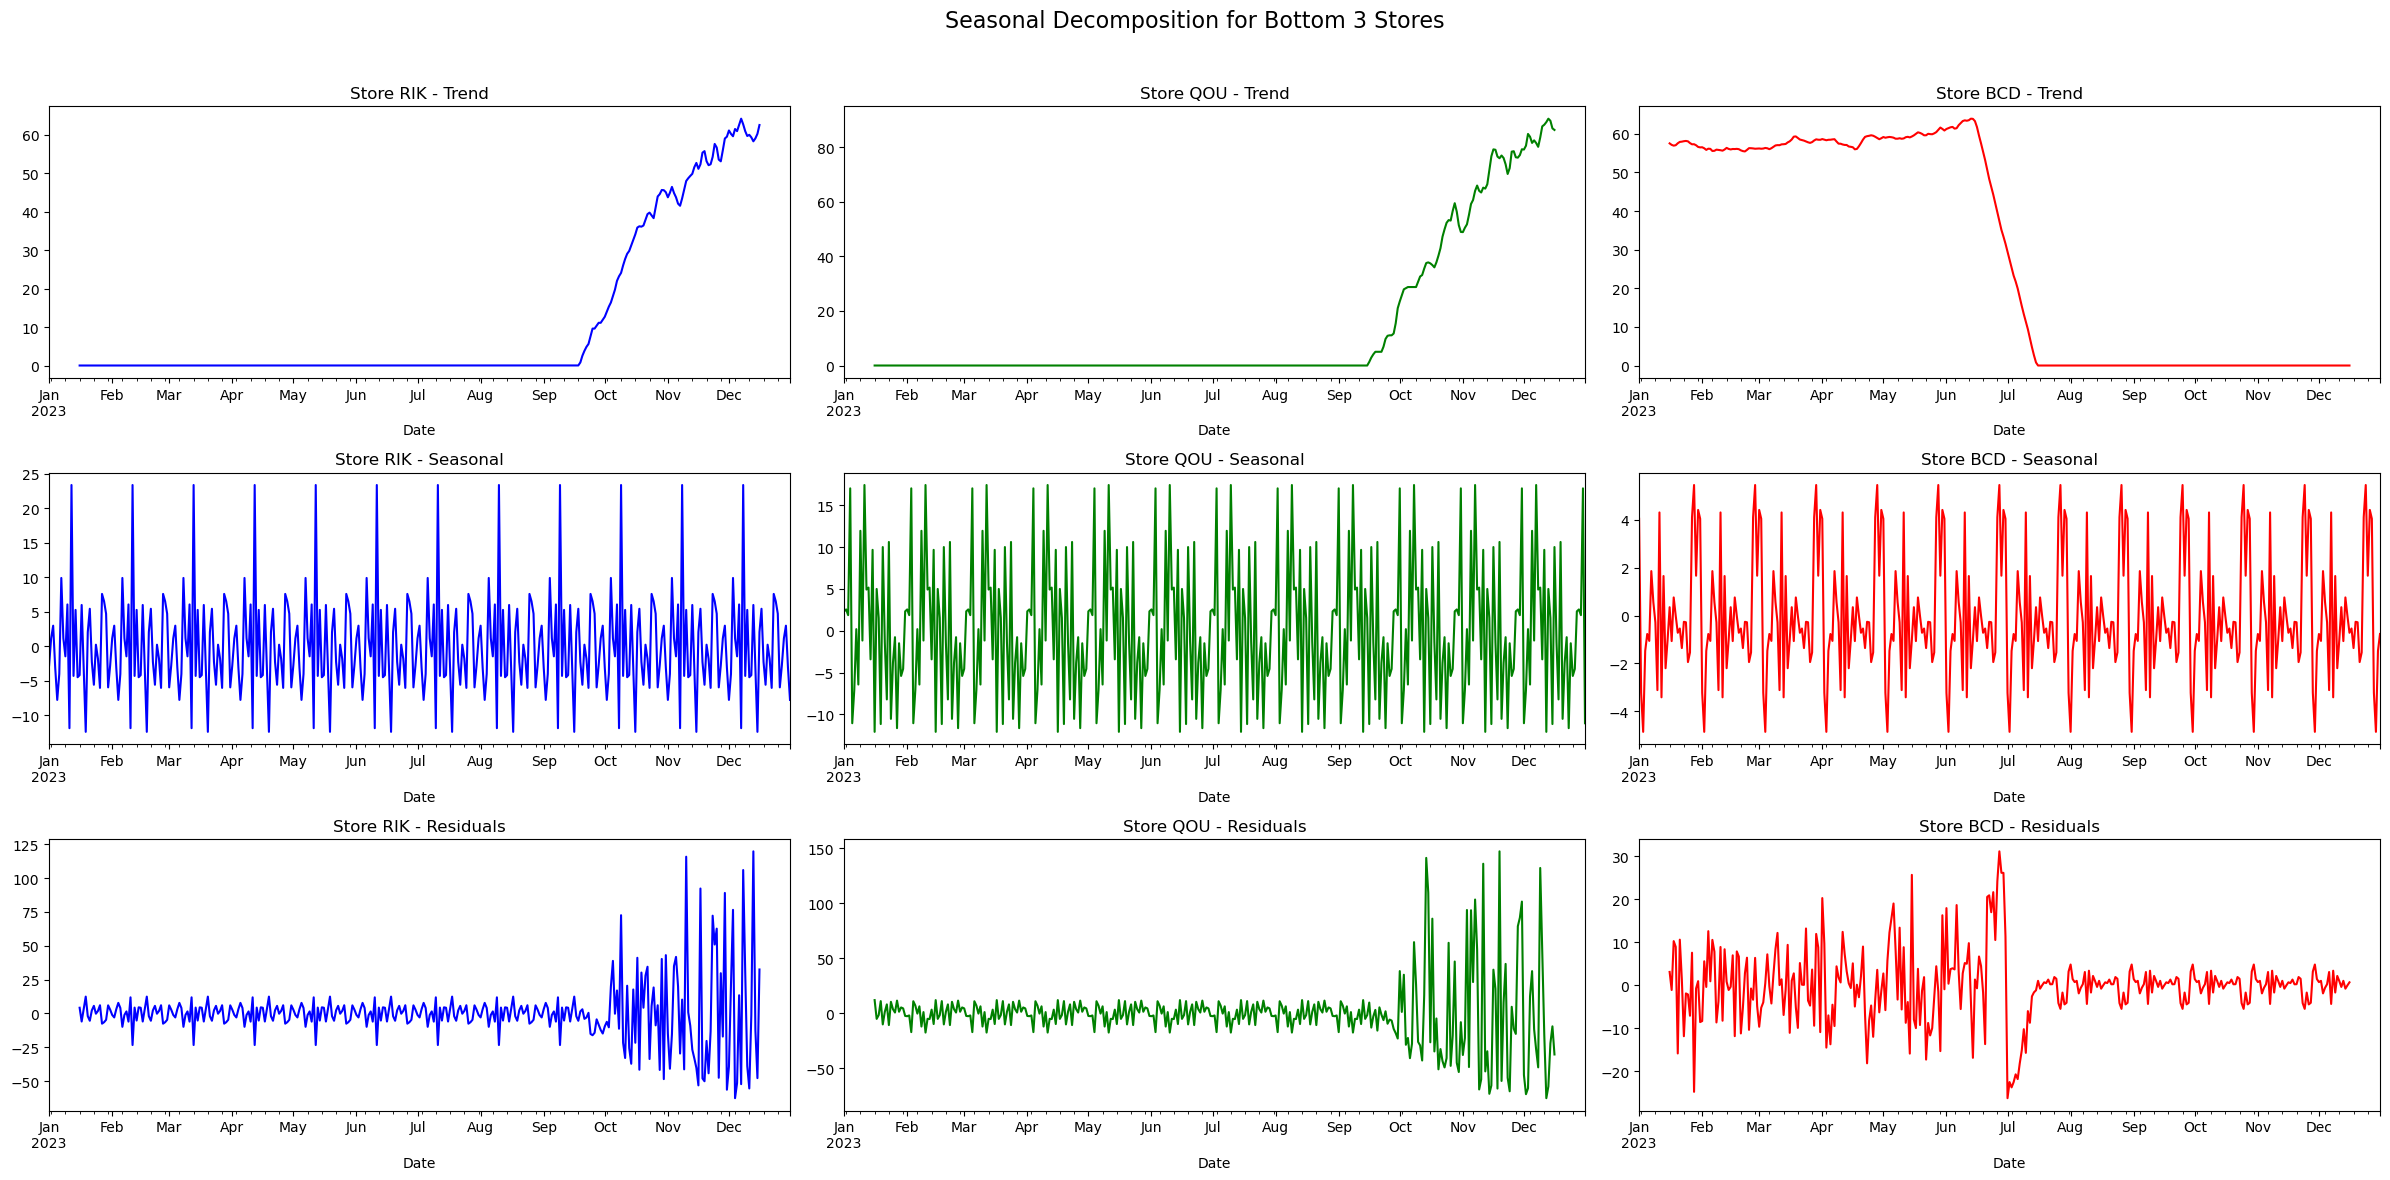

In [48]:
# Get bottom 3 stores by customer volume
top_stores = df_summary.nsmallest(3, 'Customers')['Store'].tolist()

# Plot combined seasonal decomposition
plot_seasonal_decomposition_combined(top_stores,'Bottom')

###### Saving Static Graphs

In [51]:
plt.savefig('static_visualizations.png')

<Figure size 640x480 with 0 Axes>

### 📌 Anomaly Detection & Reporting


We identify anomalies using three key criteria:
1. **Low Marketing Efficiency**: Stores with < 0.5 customers per £1 marketing spend
2. **Non-Operational Status**: Recently closed or new stores
3. **High Overheads**: Stores with overheads > £100,000


##### Define anomaly thresholds

In [57]:
marketing_threshold = 0.5  # Customers per £1
overhead_threshold = 100000  # GBP

##### Detect anomalies

In [60]:
anomalies = df_summary[
    (df_summary['CustomersPer£'] < marketing_threshold) | 
    (df_summary['Status'] != 'Operational') |
    (df_summary['Overheads (£)'] > overhead_threshold)
]

##### Display results

In [63]:
print("\n=== Identified Anomalies ===")
print(f"Marketing efficiency threshold: < {marketing_threshold} customers/£")
print(f"Overhead threshold: > £{overhead_threshold:,}\n")
print(anomalies[['Store', 'Status', 'Customers', 'Marketing (£)', 
                'Overheads (£)', 'CustomersPer£']].to_markdown(index=False))


=== Identified Anomalies ===
Marketing efficiency threshold: < 0.5 customers/£
Overhead threshold: > £100,000

| Store   | Status   |   Customers |   Marketing (£) |   Overheads (£) |   CustomersPer£ |
|:--------|:---------|------------:|----------------:|----------------:|----------------:|
| QUF     | New      |       11859 |            2000 |           83000 |          5.9295 |
| QOU     | New      |        6202 |            1000 |           76000 |          6.202  |
| BCD     | Closed   |       10594 |            1000 |           78000 |         10.594  |
| AIO     | Closed   |       16043 |            2000 |           91000 |          8.0215 |
| AQZ     | New      |       11469 |            2000 |           56000 |          5.7345 |
| RIK     | New      |        4538 |            1000 |           46000 |          4.538  |
| ZWJ     | New      |       11237 |            2000 |           97000 |          5.6185 |
